In [17]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from numba import jit, njit
from scipy.stats import  t

import warnings
warnings.filterwarnings("ignore")

In [2]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = init_state

    # Wiener Process by default
    # use @staticmethod for numba compatibility with @njit
    @staticmethod
    @njit
    def bxt(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return 1

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_t(x, t, params):
        return 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def EulerSolution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1], t_data[i - 1], self.params) * dt +\
                        self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1]
        return t_data, x_data

    @staticmethod
    @njit
    def EulerDensity(x, t, x0, t0, params, bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t):
        xs = x0 + bxt(x0, t0, params) * (t - t0)
        sigma2 = sigmaxt(x0, t0, params)**2 * (t - t0)

        return -1/2 * np.log(2 * np.pi * sigma2) - (x - xs)**2 / (2 * sigma2)

    @staticmethod
    @njit
    def OzakiDensity(x, t, x0, t0, params, bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t):
        K = 1 / (t - t0) * np.log(1 + bxt(x0, t0, params) / (x0 * bxt_x(x0, t0, params)) * (np.exp(bxt_x(x0, t0, params) * (t - t0)) - 1))
        E = x0 + bxt(x0, t0, params) / bxt_x(x0, t0, params) * (np.exp(bxt_x(x0, t0, params) * (t - t0)) - 1)
        V = sigmaxt(x0, t0, params)**2 / (2 * K) * (np.exp(2 * K * (t - t0)) - 1)

        xs = E
        sigma2 = V

        return -1/2 * np.log(2 * np.pi * sigma2) - (x - xs)**2 / (2 * sigma2)

    @staticmethod
    @njit
    def ShojiOzakiDensity(x, t, x0, t0, params, bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t):
        L = bxt_x(x0, t0, params)

        #safe division
        if L == 0:
            L = L + 0.001

        M = sigmaxt(x0, t0, params)**2 / 2 * bxt_xx(x0, t0, params) + bxt_t(x0, t0, params)

        A = 1 + bxt(x0, t0, params) / (x0 * L) * (np.exp(L * (t - t0)) - 1) + M / (x0 * L**2) * \
            (np.exp(L * (t - t0)) - 1 - L * (t - t0))
        B = sigmaxt(x0, t0, params)**2 * 1/(2 * L) * (np.exp(2 * L * (t - t0)) - 1)

        xs = A * x0
        sigma2 = B

        return -1/2 * np.log(2 * np.pi * sigma2) - (x - xs)**2 / (2 * sigma2)

    @staticmethod
    @njit
    def KesslerDensity(x, t, x0, t0, params, bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t):
        E = x0 + bxt(x0, t0, params) * (t - t0) + (bxt(x0, t0, params) * bxt_x(x0, t0, params) + 1/2 * \
            sigmaxt(x0, t0, params)**2 * bxt_xx(x0, t0, params)) * 1/2 * (t - t0)**2
        V = x0**2 + (2 * bxt(x0, t0, params) * x0 + sigmaxt(x0, t0, params)**2 ) * (t - t0)\
            + (2 * bxt(x0, t0, params) * (bxt_x(x0, t0, params) * x0 + bxt(x0, t0, params) + \
                sigmaxt(x0, t0, params) * sigmaxt_x(x0, t0, params))\
            + sigmaxt(x0, t0, params)**2 * (bxt_xx(x0, t0, params) * x0 + 2 * bxt_x(x0, t0, params) +\
                sigmaxt_x(x0, t0, params)**2 + sigmaxt(x0, t0, params) * sigmaxt_xx(x0, t0, params))) * (t - t0)**2 / 2 - E**2

        xs = E

        #safe division
        if V == 0:
            V = V + 0.001

        sigma2 = V

        return -1/2 * np.log(2 * np.pi * sigma2) - (x - xs)**2 / (2 * sigma2)

    @staticmethod
    @njit
    def MLogLik(params, t_data, x_data, density, bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t):
        Nt = len(x_data)
        Nx = len(x_data[0])
        log_data = np.zeros(Nx)
        for k in range(0, Nx):
            m_log_lik = 0
            for j in range(1, Nt):
                m_log_lik += density(x_data[j][k], t_data[j], x_data[j - 1][k], t_data[j - 1], params,
                                     bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t)
            log_data[k] = m_log_lik

        res = -np.mean(log_data)
        return res

    def EulerEstimation(self, t_data, x_data):
        x0 = np.ones(len(self.params))
        accuracy = 1e-8

        min_result = minimize(self.MLogLik,
                              x0 = x0,
                              args=(t_data, x_data, self.EulerDensity,
                              self.bxt, self.bxt_x, self.bxt_xx, self.sigmaxt, self.sigmaxt_x, self.sigmaxt_xx,
                              self.bxt_t),
                              method = 'L-BFGS-B',
                              options={'ftol': accuracy, 'eps': accuracy})
        return min_result

    def OzakiEstimation(self, t_data, x_data):
        x0 = np.ones(len(self.params))
        accuracy = 1e-8

        min_result = minimize(self.MLogLik,
                              x0 = x0,
                              args=(t_data, x_data, self.OzakiDensity,
                              self.bxt, self.bxt_x, self.bxt_xx, self.sigmaxt, self.sigmaxt_x, self.sigmaxt_xx,
                              self.bxt_t),
                              method = 'L-BFGS-B',
                              options={'ftol': accuracy, 'eps': accuracy})
        return min_result

    def ShojiOzakiEstimation(self, t_data, x_data):
        x0 = np.ones(len(self.params))
        accuracy = 1e-8

        min_result = minimize(self.MLogLik,
                              x0 = x0,
                              args=(t_data, x_data, self.ShojiOzakiDensity,
                              self.bxt, self.bxt_x, self.bxt_xx, self.sigmaxt, self.sigmaxt_x, self.sigmaxt_xx,
                              self.bxt_t),
                              method = 'L-BFGS-B',
                              options={'ftol': accuracy, 'eps': accuracy})
        return min_result

    def KesslerEstimation(self, t_data, x_data):
        x0 = np.ones(len(self.params))
        accuracy = 1e-8

        min_result = minimize(self.MLogLik,
                              x0 = x0,
                              args=(t_data, x_data, self.KesslerDensity,
                              self.bxt, self.bxt_x, self.bxt_xx, self.sigmaxt, self.sigmaxt_x, self.sigmaxt_xx,
                              self.bxt_t),
                              method = 'L-BFGS-B',
                              options={'ftol': accuracy, 'eps': accuracy})
        return min_result


class OUprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta, mu, sigma]

    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] * (params[1] - x)

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2]

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return -params[0]

    def DefaultInitState(self):
        return self.params[1] * np.ones(self.Nx)

class CKLSprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta1, theta2, theta3]
    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] + params[1] * x

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * x**params[3]

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return params[1]

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return params[2] * params[3] * x**(params[3] - 1)

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return params[2] * params[3] * (params[3] - 1) * x**(params[3] - 2)

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

class Task5process(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta1, theta2]
    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] * t * x

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[1] * x

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return params[0] * t

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return params[1]

    @staticmethod
    @njit
    def bxt_t(x, t, params):
        return params[0] * x

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

class HullWhiteprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta1, theta2, theta3]
    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] * t * (params[1] * np.sqrt(t) - x)

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * t

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return -params[0] * t

    @staticmethod
    @njit
    def bxt_t(x, t, params):
        return params[0] * params[1] * 3/2 * np.sqrt(t)

    def DefaultInitState(self):
        return self.params[1] * np.ones(self.Nx)

Task 1. Evaluate the conditional density of the Ornstein-Uhlenbeck process
$$dX_t = (3-X_t)dt+2dW_t, \quad X_0=1, \quad %\theta=(1, 3, 2), \quad
N=100000,
\quad \Delta=1$$ and calculate the
maximum likelihood estimation.  

In [3]:
Nx = 100000
Nt = 300

T = 1

params_OU = np.array([3, 1, 2])

x0 = 1
init_state = x0 * np.ones(Nx)

OUp = OUprocess(params_OU, T, Nx, Nt, init_state)

t_data, x_data_OU = OUp.EulerSolution()

In [4]:
OUp.EulerEstimation(t_data, x_data_OU)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -221.89287541295258
        x: [ 3.013e+00  9.976e-01  2.000e+00]
      nit: 16
      jac: [ 4.547e-05 -4.803e-04  1.495e-03]
     nfev: 72
     njev: 18
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [5]:
OUp.ShojiOzakiEstimation(t_data, x_data_OU)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -221.89287547903024
        x: [ 3.027e+00  9.977e-01  2.010e+00]
      nit: 16
      jac: [ 3.013e-04 -3.439e-04  1.592e-04]
     nfev: 72
     njev: 18
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [6]:
OUp.KesslerEstimation(t_data, x_data_OU)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -221.8928746552423
        x: [ 3.026e+00  9.977e-01  2.010e+00]
      nit: 15
      jac: [ 4.547e-05 -4.832e-05 -1.876e-03]
     nfev: 108
     njev: 27
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

Task. Find the maximum likelihood estimators  numerically
 for Ornstein-Uhlenbeck process
 $$
 dX_t = -\theta_2X_tdt + \theta_3dW_t, \quad \theta=(0, 3, 2), \quad
N=1000, \quad \Delta=1
$$
and compare with explicit estimations

$$
\hat{\theta}_{2,n} = -\frac{1}{\Delta}\log \left(\frac{\sum_{i=1}^n X_{i-1}X_i} {\sum_{i=1}^n X^2_{i-1}}\right),
$$
$$
\hat{\theta}_{3,n} = \sqrt{\frac{2\hat{\theta}_{2,n}}
{n(1 - e^{-2\Delta  \hat{\theta}_{2,n}})}
\sum_{i=1}^n (X_i- X_{i-1} e^{-\Delta \hat{\theta}_{2, n}})^2}.
$$

In [20]:
# Параметры процесса Орнштейна-Уленбека
theta_true = (0, 3, 2)  # theta = (theta_1, theta_2, theta_3)
N = 10 ** 6             # Количество точек
Delta = 1               # Шаг времени

# Генерация данных для процесса Орнштейна-Уленбека
np.random.seed(42)
X = np.zeros(N)
for i in range(1, N):
    X[i] = X[i-1] * np.exp(-theta_true[1] * Delta) + theta_true[2] * np.sqrt((1 - np.exp(-2 * theta_true[1] * Delta)) / (2 * theta_true[1])) * np.random.normal()

# Функция правдоподобия для численного нахождения MLE
def neg_log_likelihood(log_params, X, Delta):
    theta2, theta3 = np.exp(log_params)  # Преобразуем параметры из лог-пространства
    n = len(X) - 1
    
    # Ожидание и дисперсия переходного распределения
    expected_X = X[:-1] * np.exp(-theta2 * Delta)
    variance = (theta3**2 / (2 * theta2)) * (1 - np.exp(-2 * theta2 * Delta))
    
    # Отрицательная логарифмическая функция правдоподобия
    log_likelihood = -np.sum(-0.5 * np.log(2 * np.pi * variance) - ((X[1:] - expected_X)**2) / (2 * variance))
    return -log_likelihood

# Численное нахождение MLE для theta2 и theta3 в лог-пространстве
initial_guess = np.log([3, 2])  # Начальные приближения в лог-пространстве
mle_result = minimize(neg_log_likelihood, initial_guess, args=(X, Delta), bounds=[(None, None), (None, None)])
theta2_mle, theta3_mle = np.exp(mle_result.x)  # Возвращаемся из лог-пространства
print(f"Численные MLE оценки: theta2 = {theta2_mle:.3f}, theta3 = {theta3_mle:.3f}")

# Явные оценки
sum_Xi_Xim1 = np.sum(X[:-1] * X[1:])
sum_Xim1_sq = np.sum(X[:-1]**2)
theta2_explicit = -np.log(sum_Xi_Xim1 / sum_Xim1_sq) / Delta

# Вычисляем theta3, используя явную формулу
n = len(X)
residuals = X[1:] - X[:-1] * np.exp(-Delta * theta2_explicit)
theta3_explicit = np.sqrt((2 * theta2_explicit / (n * (1 - np.exp(-2 * Delta * theta2_explicit)))) * np.sum(residuals**2))

print(f"Явные оценки: theta2 = {theta2_explicit:.3f}, theta3 = {theta3_explicit:.3f}")

# Сравнение MLE и явных оценок
print("\nСравнение оценок:")
print(f"theta2 MLE: {theta2_mle:.3f}, theta2 Explicit: {theta2_explicit:.3f}")
print(f"theta3 MLE: {theta3_mle:.3f}, theta3 Explicit: {theta3_explicit:.3f}")

Численные MLE оценки: theta2 = 3.000, theta3 = 2.000
Явные оценки: theta2 = 3.016, theta3 = 2.006

Сравнение оценок:
theta2 MLE: 3.000, theta2 Explicit: 3.016
theta3 MLE: 2.000, theta3 Explicit: 2.006


Task 3. Consider  the Chan-Karolyi-Longstaff-Sanders (CKLS) model
$$
 dX_{t} = (\theta_{1}+\theta_{2} X_{t}) dt + \theta_{3} X_{t}^{\theta_{4}} dW_{t},\qquad X_{0}=2
$$
with $\theta_{1}=1$, $\theta_{2}=2$, $\theta_{3}=0.5$, $\theta_{4}=0.3$.

Use the Euler method and
* generate the sample data $X_{t_i}$ with time step $\Delta t =10^{-4}$,  
* estimate drift and diffusion coefficients,
* compute confidence intervals for all parameters in a fitted SDE.  


In [21]:
Nx = 1
Nt = 10000

T = 1

params_CKLS = np.array([1, 2, 0.5, 0.3])

x0 = 2
init_state = x0 * np.ones(Nx)

CKLSp = CKLSprocess(params_CKLS, T, Nx, Nt, init_state)

t_data, x_data_CKLS = CKLSp.EulerSolution()

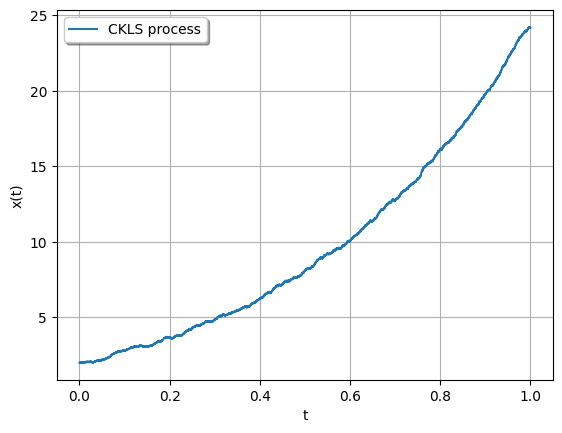

In [22]:
plt.plot(t_data, x_data_CKLS[:,0], label = 'CKLS process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

In [23]:
CKLSp.EulerEstimation(t_data, x_data_CKLS)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -32667.60267461704
        x: [ 1.110e+00  2.123e+00  5.103e-01  2.907e-01]
      nit: 18
      jac: [-1.191e+00  1.095e-01 -3.238e-02  2.474e-02]
     nfev: 110
     njev: 22
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [24]:
#Confidence intervals
n = 50
result = np.zeros((n, 4))
for k in range(0, n):
    t_data, x_data_CKLS = CKLSp.EulerSolution()
    result[k] = CKLSp.EulerEstimation(t_data, x_data_CKLS).x


alpha = 0.05
q = t.ppf(1-alpha/2, n - 1)
for i in range(0, 4):
    m = np.mean(result[:,i])
    v = np.std(result[:,i], ddof=1)
    print(f"theta{i} = {m} +- {v * q / np.sqrt(n)} with {100 - alpha * 100}% prob")

theta0 = 1.077065753220165 +- 0.17206153835716004 with 95.0% prob
theta1 = 1.9627229528579015 +- 0.04354715881078065 with 95.0% prob
theta2 = 0.49978848630860107 +- 0.00290251791285851 with 95.0% prob
theta3 = 0.3017706624710788 +- 0.0031584048441845366 with 95.0% prob


Task 4. Consider the Vasicek model
$$
dX_{t} = \theta_{1} (\theta_{2}- X_{t}) dt + \theta_{3} dW_{t},\qquad X_{0}=5
$$
with $\theta_{1}=3$, $\theta_{2}=2$ and $\theta_{3}=0.5$.

Use the Ozaki method and
*   generate the sample data $X_{t_i}$, time step $\Delta t =10^{-2}$,
*   estimate drift and diffusion coefficients,
*   compute confidence intervals for all parameters in a fitted SDE.

In [25]:
Nx = 1
Nt = 100

T = 1

params_OU = np.array([3, 2, 0.5])

x0 = 5
init_state = x0 * np.ones(Nx)

OUp = OUprocess(params_OU, T, Nx, Nt, init_state)

t_data, x_data_OU = OUp.EulerSolution()

In [26]:
OUp.OzakiEstimation(t_data, x_data_OU)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -163.28153395447106
        x: [ 3.564e+00  2.069e+00  4.748e-01]
      nit: 22
      jac: [-1.137e-05  7.390e-05 -8.242e-05]
     nfev: 120
     njev: 30
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [27]:
#Confidence intervals
n = 50
result = np.zeros((n, 3))
for k in range(0, n):
    t_data, x_data_OU = OUp.EulerSolution()
    result[k] = OUp.OzakiEstimation(t_data, x_data_OU).x


alpha = 0.05
q = t.ppf(1-alpha/2, n - 1)
for i in range(0, 3):
    m = np.mean(result[:,i])
    v = np.std(result[:,i], ddof=1)
    print(f"theta{i} = {m} +- {v * q / np.sqrt(n)} with {100 - alpha * 100}% prob")

theta0 = 3.228919405491875 +- 0.19419025842396742 with 95.0% prob
theta1 = 2.042761643396121 +- 0.07938407574113324 with 95.0% prob
theta2 = 0.32073952700923825 +- 0.10989018863360837 with 95.0% prob


Task 5. Consider the model
$$
  dX_{t} = a(t)X_{t} dt + \theta_{2}X_{t} dW_{t},\qquad X_{0}=10
$$
with $a(t) = \theta_{1}t$, $\theta_{1}=-2$, $\theta_{2}=0.2$.

Use the Shoji-Ozaki method and:
* generate the sample data $X_{t_i}$ time step $\Delta t =10^{-3}$,  
* estimate drift and diffusion coefficients,
* compute confidence intervals for all parameters in a fitted SDE.

In [28]:
Nx = 1
Nt = 1000

T = 1

params_T5 = np.array([-2, 0.2])

x0 = 5
init_state = x0 * np.ones(Nx)

T5p = Task5process(params_T5, T, Nx, Nt, init_state)

t_data, x_data_T5 = T5p.EulerSolution()

In [29]:
T5p.ShojiOzakiEstimation(t_data, x_data_T5)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -2664.290717579065
        x: [-2.643e+00  1.984e-01]
      nit: 14
      jac: [ 4.907e-02  1.046e-03]
     nfev: 129
     njev: 43
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

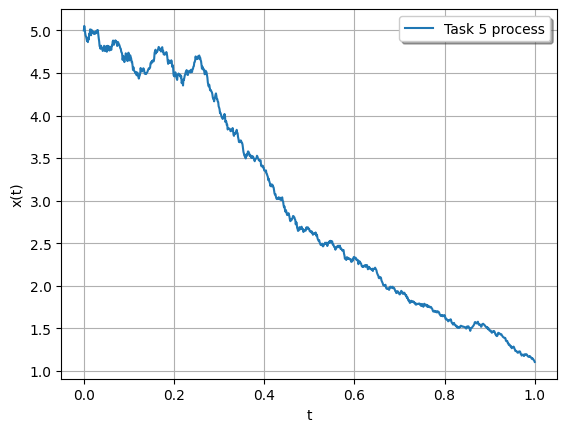

In [30]:
plt.plot(t_data, x_data_T5[:,0], label = 'Task 5 process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

In [31]:
#Confidence intervals
n = 50
result = np.zeros((n, 2))
for k in range(0, n):
    t_data, x_data_T5 = T5p.EulerSolution()
    result[k] = T5p.ShojiOzakiEstimation(t_data, x_data_T5).x


alpha = 0.05
q = t.ppf(1-alpha/2, n - 1)
for i in range(0, 2):
    m = np.mean(result[:,i])
    v = np.std(result[:,i], ddof=1)
    print(f"theta{i} = {m} +- {v * q / np.sqrt(n)} with {100 - alpha * 100}% prob")

theta0 = -2.0350935936355374 +- 0.10484038542147221 with 95.0% prob
theta1 = 0.1918824132273996 +- 0.016288549467665468 with 95.0% prob


Task 6. Consider the Hull-White (extended Vasicek) model
$$
  dX_{t} = a(t)(b(t)-X_{t}) dt + \sigma(t) dW_{t},\qquad X_{0}=2
$$
with $a(t) = \theta_{1}t$, $b(t)=\theta_{2}\sqrt{t}$, the volatility depends on time $\sigma(t)=\theta_{3}t$.

Generate sample data of $X_t$ with time step $\Delta t =10^{-3}$ and $\theta_{1}=3$, $\theta_{2}=1$ and $\theta_{3}=0.3$, then
use the Kessler method and:
*   estimate drift and diffusion coefficients,
*   compute confidence intervals for all parameters in a fitted SDE.

In [32]:
Nx = 1
Nt = 100

T = 1

params_HW = np.array([3, 1, 0.3])

x0 = 2
init_state = x0 * np.ones(Nx)

HWp = HullWhiteprocess(params_HW, T, Nx, Nt, init_state)

t_data, x_data_HW = HWp.EulerSolution()

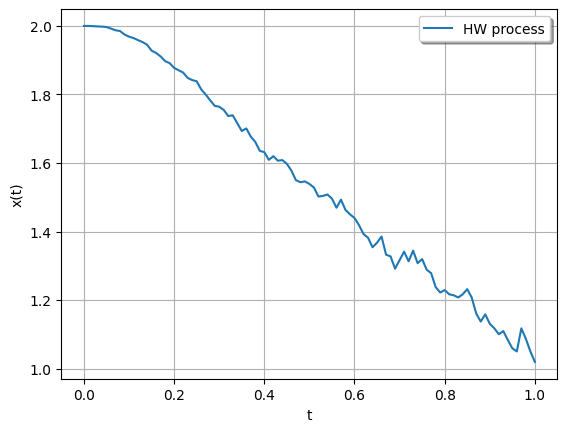

In [33]:
plt.plot(t_data, x_data_HW[:,0], label = 'HW process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

In [34]:
HWp.KesslerEstimation(t_data, x_data_HW)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -305.3124501065398
        x: [ 3.443e+00  1.006e+00  3.032e-01]
      nit: 15
      jac: [ 2.212e-01  5.437e-01  6.888e-02]
     nfev: 144
     njev: 36
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

Task. Take a process from previous tasks and approximation method, find the solution, compute confidence intervals, and compare results with baseline.

Plot the graph and table.

Задания по вариантам
1. Байков Илья Павлович OU + Kessler
1. Гонгапшев Астемир Султанович CKLS + Shoji-Ozaki
1. Кудинкина Екатерина Андреевна CKLS + Kessler
1. Кулига Андрей Владимирович Vasicek + Euler
1. Мартыненко Александр Станиславович Vasicek + Shoji-Ozaki
1. Мироманов Даниил Борисович Vasicek + Kessler
1. Паршаков Никита Сергеевич extended Vasicek + Euler
1. Петренко Влада Витальевна extended Vasicek + Ozaki
1. Тумачев Серафим Дмитриевич extended Vasicek + Shoji-Ozaki
1. Хубиев Касымхан Юсуфович model 5 + Euler
1. Ширяева Софья Игоревна model 5 + Ozaki
1. Якунин Сергей Александрович model 5 + Kessler
1. Трофимов Яков Георгиевич CKLS + Ozaki


Оценки параметров методом Кесслера: theta1 = -1.971, theta2 = 0.202

Доверительные интервалы для параметров (95%):
Параметр 1: (-65.37994810684064, 61.437540876622)
Параметр 2: (0.131079942973457, 0.2728372835010543)


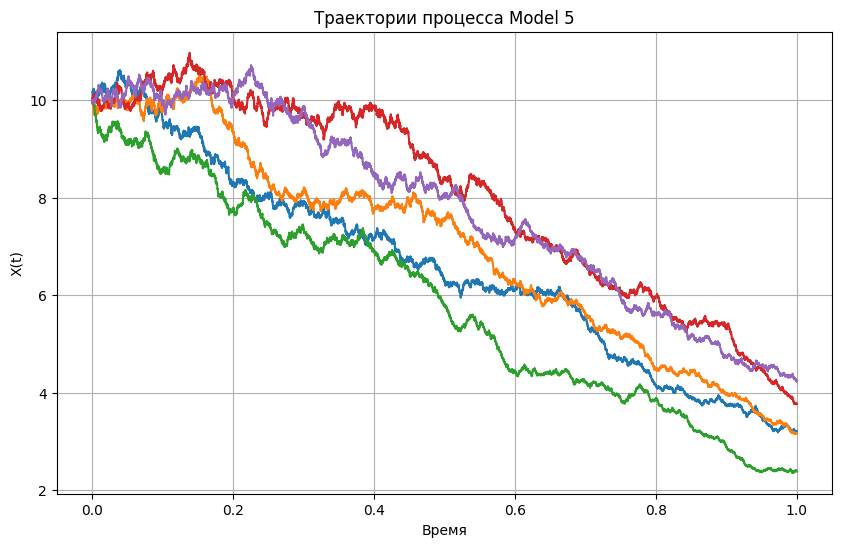

,Параметр,Kessler Оценка,CI Lower (95%),CI Upper (95%)
0,theta_1,-1.971204,-65.379948,61.437541
1,theta_2,0.201959,0.131080,0.272837


In [46]:
from scipy.optimize import minimize
import pandas as pd

class Model5Process:
    def __init__(self, params, T, Nx, Nt, init_state=None):
        self.params = params
        self.T = T
        self.Nx = Nx
        self.Nt = Nt
        self.init_state = init_state if init_state is not None else np.ones(Nx)

    def drift(self, x, t):
        theta1 = self.params[0]
        return theta1 * t * x

    def diffusion(self, x):
        theta2 = self.params[1]
        return theta2 * x

    def drift_derivative_t(self, x, t):
        return self.params[0] * x  # Производная дрейфа по времени

    def generate_trajectory(self):
        X = np.zeros((self.Nt, self.Nx))
        X[0, :] = self.init_state
        dt = self.T / self.Nt
        for i in range(1, self.Nt):
            t = i * dt
            drift = self.drift(X[i-1, :], t) * dt
            diffusion = self.diffusion(X[i-1, :]) * np.sqrt(dt) * np.random.normal(size=self.Nx)
            X[i, :] = X[i-1, :] + drift + diffusion
        return np.linspace(0, self.T, self.Nt), X

    def KesslerDensity(self, x_next, x_current, t, params):
        # Плотность вероятности для метода Кесслера
        theta1, theta2 = params
        dt = self.T / self.Nt
        drift = theta1 * t * x_current * dt
        diffusion = theta2 * x_current * np.sqrt(dt)
        residual = (x_next - x_current - drift) / diffusion
        return -0.5 * np.log(2 * np.pi * diffusion**2) - (residual**2) / 2

    def MLogLik(self, params, t_data, x_data, density_func, bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t):
        # Вычисление отрицательной логарифмической функции правдоподобия по методу Кесслера
        log_likelihood = 0
        for i in range(1, len(t_data)):
            log_likelihood += density_func(x_data[i], x_data[i-1], t_data[i-1], params)
        return -log_likelihood

    def KesslerEstimation(self, t_data, x_data):
        # Метод Кесслера для оценки параметров
        x0 = np.ones(len(self.params))
        accuracy = 1e-8
        min_result = minimize(
            self.MLogLik,
            x0=x0,
            args=(t_data, x_data, self.KesslerDensity, self.drift, None, None, self.diffusion, None, None, self.drift_derivative_t),
            method='L-BFGS-B',
            options={'ftol': accuracy, 'eps': accuracy}
        )
        return min_result

# Параметры модели
params = [-2, 0.2]  # theta_1=-2, theta_2=0.2
T = 1
Nx = 10000
Nt = 10000
init_state = np.ones(Nx) * 10

# Создаем процесс
model5_process = Model5Process(params, T, Nx, Nt, init_state)

# Генерируем данные и оцениваем параметры
t_data, x_data = model5_process.generate_trajectory()
result_kessler = model5_process.KesslerEstimation(t_data, x_data[:, 0])

# Оцененные параметры
theta_estimated = result_kessler.x
print(f"Оценки параметров методом Кесслера: theta1 = {theta_estimated[0]:.3f}, theta2 = {theta_estimated[1]:.3f}")

# Доверительные интервалы
hessian_inv = result_kessler.hess_inv.todense() if hasattr(result_kessler.hess_inv, 'todense') else np.linalg.inv(result_kessler.hess_inv)
std_errors = np.sqrt(np.diag(hessian_inv))
confidence_intervals = [
    (theta_estimated[i] - 1.96 * std_errors[i], theta_estimated[i] + 1.96 * std_errors[i])
    for i in range(len(theta_estimated))
]

print("\nДоверительные интервалы для параметров (95%):")
for i, ci in enumerate(confidence_intervals):
    print(f"Параметр {i+1}: {ci}")

# Построение графика траекторий
plt.figure(figsize=(10, 6))
plt.plot(t_data, x_data[:, :5])  # Показываем 5 траекторий
plt.title('Траектории процесса Model 5')
plt.xlabel('Время')
plt.ylabel('X(t)')
plt.grid(True)
plt.show()

# Создание таблицы результатов
table_data = {
    'Параметр': ['theta_1', 'theta_2'],
    'Kessler Оценка': theta_estimated,
    'CI Lower (95%)': [ci[0] for ci in confidence_intervals],
    'CI Upper (95%)': [ci[1] for ci in confidence_intervals],
}
df_results = pd.DataFrame(table_data)
df_results